In [2]:
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pylab
import os
#os.chdir("data")
import pandas as pd
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import time

In [3]:
data = pq.read_table('./data/fhvhv_tripdata_2021-01.parquet')
data=data.to_pandas()

# files=[file for file in os.listdir()]
# allfiles=pd.DataFrame()
# for file in files:
#     df=pq.read_table(file)
#     df=df.to_pandas()
#     allfiles=pd.concat([allfiles,df])
# allfile.to_csv("allfile.csv",index=False)

In [3]:
data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.26,...,1.98,2.75,NaN,0.00,14.99,N,N,,N,N
1,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.65,...,1.63,0.00,NaN,0.00,17.06,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.51,...,1.25,2.75,NaN,0.94,12.98,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.74,...,0.70,2.75,NaN,0.00,7.41,N,N,,N,N
4,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.20,...,2.41,2.75,NaN,0.00,22.44,N,N,,N,N


In [4]:
print(data['hvfhs_license_num'].value_counts())
uber=data[data['hvfhs_license_num']=="HV0003"]
print(uber.shape)

HV0003    8704128
HV0005    3094325
HV0004     110015
Name: hvfhs_license_num, dtype: int64
(8704128, 24)


### FEATURES ADDING

In [5]:
uber[['base_passenger_fare','tolls','sales_tax','congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']].head()
uber['airport_fee'].fillna(0, inplace=True)
uber['date']=uber['on_scene_datetime'].dt.day
uber['hrs']=uber['pickup_datetime'].dt.hour
uber['day']=uber['pickup_datetime'].dt.day_name()
uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']+uber['sales_tax']
uber['request_datetime']=pd.to_datetime(uber['request_datetime'])
uber['pick_drop_time'] = pd.to_datetime(uber['dropoff_datetime'], format='%H:%M:%S') - pd.to_datetime(uber['pickup_datetime'], format='%H:%M:%S')
uber['request_onseen'] = pd.to_datetime(uber['on_scene_datetime'], format='%M') - pd.to_datetime(uber['request_datetime'], format='%M')
uber['base_passenger_fare'] = uber['base_passenger_fare'].abs()
uber['driver_pay']=uber['driver_pay'].abs()
uber['uber_earnings']=uber['uber_earnings'].abs()
uber.tail()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,date,hrs,day,uber_earnings,pick_drop_time,request_onseen
11908463,HV0003,B02765,B02765,2021-01-31 23:13:51,2021-01-31 23:25:03,2021-01-31 23:25:40,2021-01-31 23:40:10,89,71,2.29,...,N,,N,N,31,23,Sunday,6.21,0 days 00:14:30,0 days 00:11:12
11908464,HV0003,B02872,B02872,2021-01-31 23:23:56,2021-01-31 23:29:03,2021-01-31 23:29:31,2021-01-31 23:47:44,182,167,4.10,...,N,,N,N,31,23,Sunday,7.06,0 days 00:18:13,0 days 00:05:07
11908465,HV0003,B02872,B02872,2021-01-31 23:42:53,2021-01-31 23:49:23,2021-01-31 23:49:32,2021-02-01 00:04:36,167,169,2.40,...,N,,N,N,31,23,Sunday,5.73,0 days 00:15:04,0 days 00:06:30
11908466,HV0003,B02764,B02764,2021-01-31 23:04:32,2021-01-31 23:09:13,2021-01-31 23:09:29,2021-01-31 23:27:46,188,37,3.60,...,N,,N,N,31,23,Sunday,4.27,0 days 00:18:17,0 days 00:04:41
11908467,HV0003,B02764,B02764,2021-01-31 23:22:20,2021-01-31 23:28:33,2021-01-31 23:28:33,2021-01-31 23:56:36,37,4,5.76,...,N,,N,N,31,23,Sunday,19.63,0 days 00:28:03,0 days 00:06:13


#                            UBER ANALYSIS IN JANUARRY


## TOTAL UBER EARNINGS

In [8]:
print("TOTAL EARNINGS IN JANNUARY MONTH:",locale.currency(round(uber['uber_earnings'].sum()), grouping=True))


TOTAL EARNINGS IN JANNUARY MONTH: $59,125,118.00


## TOTAL SALES TAXES COLLECTED BY NYC GOVT THROUGH UBER

In [9]:
print("TOTAL TAXES EARNED BY GOVT IN ONE MONTH",locale.currency(round(uber['sales_tax'].sum()), grouping=True))

TOTAL TAXES EARNED BY GOVT IN ONE MONTH $12,766,994.00


## TOTAL TOLLS COLLECTED IN ONE MONTH


In [10]:
print("TOTAL TAXES EARNED BY GOVT IN ONE MONTH",locale.currency(round(uber['tolls'].sum()), grouping=True))

TOTAL TAXES EARNED BY GOVT IN ONE MONTH $5,880,263.00


## WHATS THE PEAK HRS OF REQUEST ?

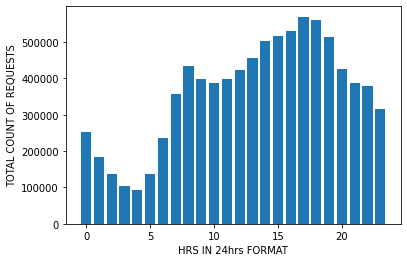

In [11]:
hrs=uber['request_datetime'].dt.hour
plt.bar(hrs.value_counts().index,hrs.value_counts().values)
plt.xlabel("HRS IN 24hrs FORMAT")
plt.ylabel("TOTAL COUNT OF REQUESTS")
plt.show()


## AT WHICH DAY THE DEMAND IS HIGH ?

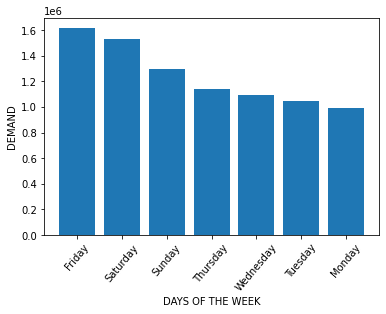

In [38]:
plt.bar(uber['day'].value_counts().index[:10],uber['day'].value_counts().values[:10])
plt.xlabel("DAYS OF THE WEEK")
plt.ylabel("DEMAND")
plt.xticks(rotation=50)
plt.show()


## WHATS MOST COMMON PICKUP AND DROP LOCATION ??

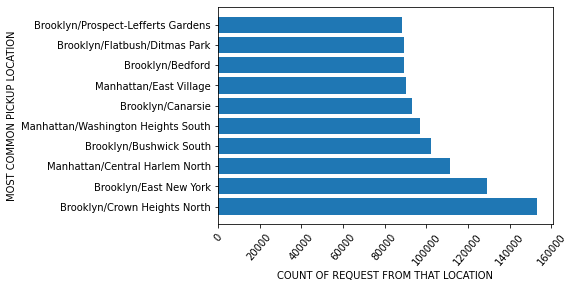

In [12]:
lookup=pd.read_csv('taxi_zone_lookup.csv')

a=uber['PULocationID'].value_counts().index[:10]
b=uber['PULocationID'].value_counts().values[:10]
loc=[]
for i in a:
    loc.append(lookup['loc'][i-1])
loc
plt.barh(loc,width=b)
plt.ylabel("MOST COMMON PICKUP LOCATION")
plt.xlabel("COUNT OF REQUEST FROM THAT LOCATION")
plt.xticks(rotation=50)
plt.show()

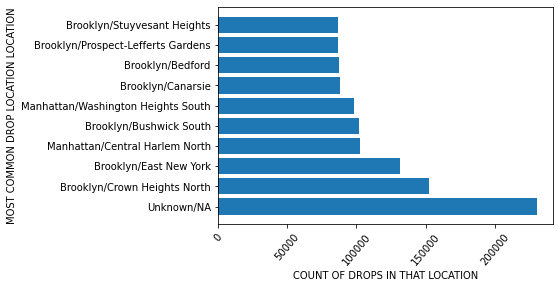

In [13]:
a=uber['DOLocationID'].value_counts().index[:10]
b=uber['DOLocationID'].value_counts().values[:10]
loc=[]
for i in a:
    loc.append(lookup['loc'][i-1])
loc
plt.barh(loc,width=b)
plt.ylabel("MOST COMMON DROP LOCATION LOCATION")
plt.xlabel("COUNT OF DROPS IN THAT LOCATION")
plt.xticks(rotation=50)
plt.show()

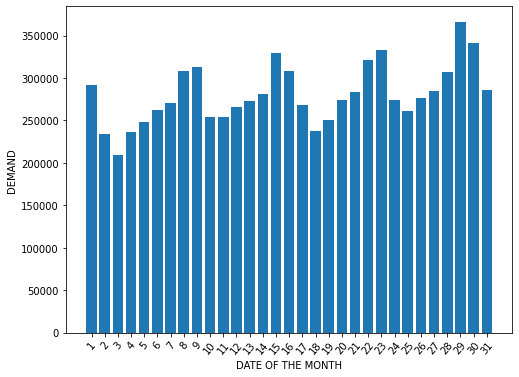

In [134]:
plt.figure(figsize=(8,6))
plt.bar(uber['date'].value_counts().index,uber['date'].value_counts().values)

plt.xlabel("DATE OF THE MONTH")
plt.ylabel("DEMAND")
plt.xticks(list(range(1,32)))
plt.xticks(rotation=90)
plt.xticks(rotation=50)

plt.show()


## average time driver took to pickup passenger when they requested

In [25]:
uber['pick_drop_time'].mean()

Timedelta('0 days 00:15:44.927309547')

## Is there a correlation between trip distance and fare amounts?

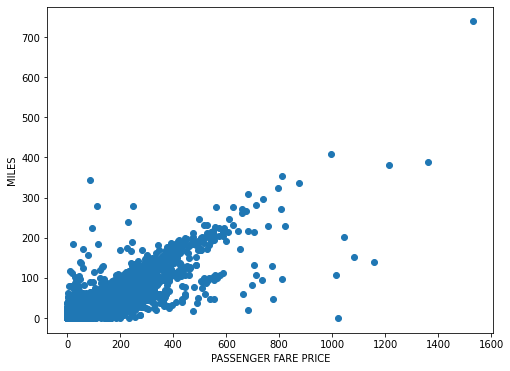

In [40]:
plt.figure(figsize=(8,6))
plt.scatter(uber['base_passenger_fare'],uber['trip_miles'])
plt.xlabel("PASSENGER FARE PRICE")
plt.ylabel("MILES")
plt.show()

## How does trip time vary based on factors like time of day or day of the week?

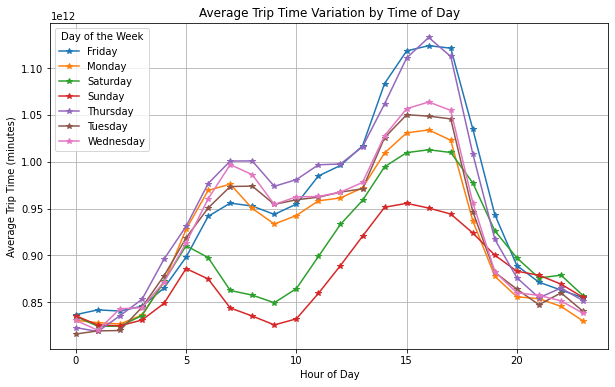

In [139]:
grouped_data = uber.groupby(['day', 'hrs'])
average_trip_time_series = grouped_data['pick_drop_time'].mean()
average_trip_time = average_trip_time_series.reset_index()
pivot_table = average_trip_time.pivot(index='hrs', columns='day', values='pick_drop_time')

plt.figure(figsize=(10,6))
for day in average_trip_time['day'].unique():
    day_data = average_trip_time[average_trip_time['day'] == day]
    plt.plot(day_data['hrs'], day_data['pick_drop_time'], label=day,marker="*")

plt.title('Average Trip Time Variation by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Time (minutes)')
plt.legend(title='Day of the Week', loc='upper left')
plt.grid(True)
plt.show()

In [41]:
uber.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'date', 'hrs', 'day',
       'pick_drop_time', 'request_onseen', 'uber_earnings'],
      dtype='object')

## corelation between total_miles request_responcetime  base_passenger_fare uber_earnings tolls trip_time

<Figure size 720x576 with 0 Axes>

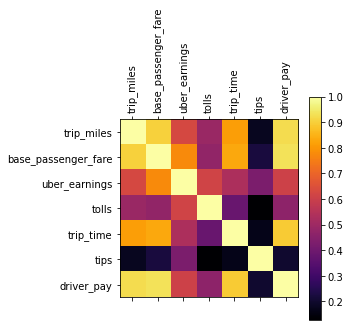

,trip_miles,base_passenger_fare,uber_earnings,tolls,trip_time,tips,driver_pay
trip_miles,1.000000,0.904130,0.628638,0.489399,0.815984,0.178147,0.922029
base_passenger_fare,0.904130,1.000000,0.777494,0.473399,0.831233,0.221878,0.932936
uber_earnings,0.628638,0.777494,1.000000,0.612010,0.530221,0.425032,0.608232
tolls,0.489399,0.473399,0.612010,1.000000,0.384894,0.127900,0.464965
trip_time,0.815984,0.831233,0.530221,0.384894,1.000000,0.166682,0.891850
tips,0.178147,0.221878,0.425032,0.127900,0.166682,1.000000,0.200913
driver_pay,0.922029,0.932936,0.608232,0.464965,0.891850,0.200913,1.000000


In [141]:
c=uber[['trip_miles','base_passenger_fare','uber_earnings','tolls','trip_time','tips', 'driver_pay']]

cor= c.corr()
plt.figure(figsize=(10, 8))
cax = plt.matshow(cor, cmap='inferno')
plt.colorbar(cax)

labels =['trip_miles','base_passenger_fare','uber_earnings','tolls','trip_time','tips', 'driver_pay']
plt.yticks(np.arange(len(labels)), labels)
plt.xticks(np.arange(len(labels)), labels, rotation=90)

plt.show()
cor

## BOXPLOT TO UNDERSTAND PEAK TIMES 

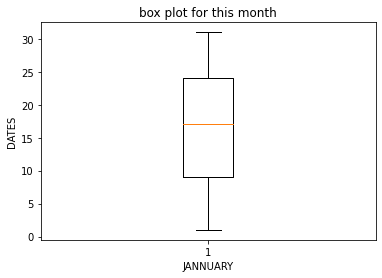

In [118]:
plt.boxplot(uber['date'])
plt.ylabel('DATES')
plt.xlabel("JANNUARY")
plt.title("box plot for this month")
plt.show()


## CORELATION BETWEEN WEATHER DATA

,temp,humidity,visibility,precip,snow,snowdepth,windspeed,cloudcover
temp,1.000000,0.249578,0.074539,0.116416,-0.323547,-0.447227,-0.203916,-0.055964
humidity,0.249578,1.000000,-0.612629,0.350970,0.068964,-0.018511,-0.170986,0.696128
visibility,0.074539,-0.612629,1.000000,-0.450561,-0.403306,-0.198394,-0.064097,-0.499583
precip,0.116416,0.350970,-0.450561,1.000000,0.080615,-0.013178,0.180164,0.281845
snow,-0.323547,0.068964,-0.403306,0.080615,1.000000,0.523152,0.134535,0.082155
snowdepth,-0.447227,-0.018511,-0.198394,-0.013178,0.523152,1.000000,0.071174,0.096436
windspeed,-0.203916,-0.170986,-0.064097,0.180164,0.134535,0.071174,1.000000,0.021172
cloudcover,-0.055964,0.696128,-0.499583,0.281845,0.082155,0.096436,0.021172,1.000000


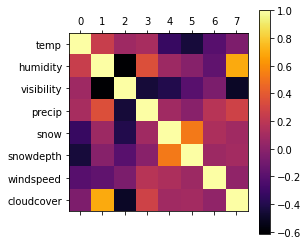

In [12]:
weather=pd.read_csv('nyc 2021-01-01 to 2021-12-31.csv')
weatherdata=weather[['datetime', 'temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover']]
w=weatherdata.corr()
we=plt.matshow(w, cmap='inferno')
plt.colorbar(we)
labels =['temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover']
plt.yticks(np.arange(len(labels)), labels)
w

## FINDING THE  RELATION BETWEEN WEATHER AND UBER EARNINGS

0:09:56.871288
                temp  humidity  visibility    precip      snow  snowdepth  \
temp        1.000000  0.249578    0.074539  0.116416 -0.323547  -0.447227   
humidity    0.249578  1.000000   -0.612629  0.350970  0.068964  -0.018511   
visibility  0.074539 -0.612629    1.000000 -0.450561 -0.403306  -0.198394   
precip      0.116416  0.350970   -0.450561  1.000000  0.080615  -0.013178   
snow       -0.323547  0.068964   -0.403306  0.080615  1.000000   0.523152   
snowdepth  -0.447227 -0.018511   -0.198394 -0.013178  0.523152   1.000000   
windspeed  -0.203916 -0.170986   -0.064097  0.180164  0.134535   0.071174   
cloudcover -0.055964  0.696128   -0.499583  0.281845  0.082155   0.096436   
uber        0.342340  0.061653    0.132385 -0.025721 -0.306731  -0.390287   

            windspeed  cloudcover      uber  
temp        -0.203916   -0.055964  0.342340  
humidity    -0.170986    0.696128  0.061653  
visibility  -0.064097   -0.499583  0.132385  
precip       0.180164    0.281

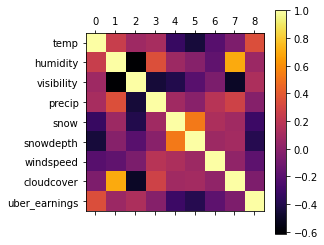

In [14]:
import datetime
startTime = datetime.datetime.now()
earning=[]
for filename in os.listdir('./data/'):
    file_path = os.path.join('./data/', filename)
    data = pq.read_table(file_path)
    data=data.to_pandas()
    uber=data[data['hvfhs_license_num']=="HV0003"]
    uber['date']=uber['on_scene_datetime'].dt.day
    uber['airport_fee'].fillna(0, inplace=True)
    uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']-uber['sales_tax']
    data=uber.groupby('date').sum()
    data=data['uber_earnings']
    for i in data:
        earning.append(i)
endTime = datetime.datetime.now()
print(endTime - startTime)

weather=pd.read_csv('nyc 2021-01-01 to 2021-12-31.csv')
weather['uber']=earning[:365]
weather=weather[[ 'temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover','uber']]
=weather.corr()

w=plt.matshow(weatherdata,cmap='inferno')
plt.colorbar(w)
labels =[ 'temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover','uber_earnings']
plt.yticks(np.arange(len(labels)), labels)
print(weatherdata)
plt.show()


In [16]:
weatherdata

,temp,humidity,visibility,precip,snow,snowdepth,windspeed,cloudcover,uber
temp,1.000000,0.249578,0.074539,0.116416,-0.323547,-0.447227,-0.203916,-0.055964,0.342340
humidity,0.249578,1.000000,-0.612629,0.350970,0.068964,-0.018511,-0.170986,0.696128,0.061653
visibility,0.074539,-0.612629,1.000000,-0.450561,-0.403306,-0.198394,-0.064097,-0.499583,0.132385
precip,0.116416,0.350970,-0.450561,1.000000,0.080615,-0.013178,0.180164,0.281845,-0.025721
snow,-0.323547,0.068964,-0.403306,0.080615,1.000000,0.523152,0.134535,0.082155,-0.306731
snowdepth,-0.447227,-0.018511,-0.198394,-0.013178,0.523152,1.000000,0.071174,0.096436,-0.390287
windspeed,-0.203916,-0.170986,-0.064097,0.180164,0.134535,0.071174,1.000000,0.021172,-0.182761
cloudcover,-0.055964,0.696128,-0.499583,0.281845,0.082155,0.096436,0.021172,1.000000,-0.054332
uber,0.342340,0.061653,0.132385,-0.025721,-0.306731,-0.390287,-0.182761,-0.054332,1.000000


## CONCATING LAST 2 MONTHS DATASETS

In [2]:
# import datetime
# startTime = datetime.datetime.now()
# quarterdata=pd.DataFrame()
# for file in ['./data/fhvhv_tripdata_2021-11.parquet','./data/fhvhv_tripdata_2021-12.parquet']:
#     uber=pq.read_table(file)
#     uber=uber.to_pandas()
#     uber=uber[uber['hvfhs_license_num']=="HV0003"]
#     uber['date']=uber['on_scene_datetime'].dt.day
#     uber['hrs']=uber['pickup_datetime'].dt.hour
#     uber['day']=uber['pickup_datetime'].dt.day_name()
#     uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']+uber['sales_tax']
#     uber['request_datetime']=pd.to_datetime(uber['request_datetime'])
#     uber['pick_drop_time'] = pd.to_datetime(uber['dropoff_datetime'], format='%H:%M:%S') - pd.to_datetime(uber['pickup_datetime'], format='%H:%M:%S')
#     uber['request_onseen'] = pd.to_datetime(uber['on_scene_datetime'], format='%M') - pd.to_datetime(uber['request_datetime'], format='%M')
#     uber['base_passenger_fare'] = uber['base_passenger_fare'].abs()
#     uber['driver_pay']=uber['driver_pay'].abs()
#     uber['uber_earnings']=uber['uber_earnings'].abs()
#     uber=uber[['trip_miles','pickup_datetime',
#        'trip_time', 'base_passenger_fare', 'tolls', 'sales_tax',
#        'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
#        'date', 'hrs', 'day','pick_drop_time', 'request_onseen', 'uber_earnings']]
#     quarterdata=pd.concat([quarterdata,uber])
# quarterdata.to_csv("quarterdata.csv",index=False)
# endTime = datetime.datetime.now()
# print(endTime - startTime)

0:11:58.783422


In [7]:
data = pd.read_csv('quarterdata.csv')
data.head()
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['sincestart'] = (data['pickup_datetime'].dt.date - data['pickup_datetime'].min().date()).dt.days

## BUILDNG AND TRAILING A MODEL


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = ['sincestart', 'trip_miles', 'base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
x= data[features]
y = data['uber_earnings']
 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
model.score(X_test, y_test)

0.9261372630201493

## PREDICTION ACCURECY


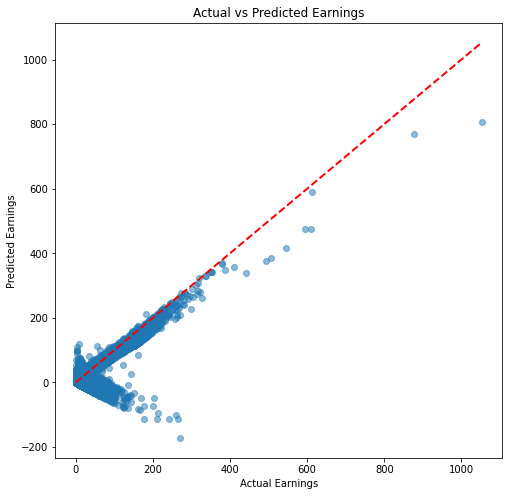

In [12]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5)  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)  
plt.title('Actual vs Predicted Earnings')
plt.xlabel('Actual Earnings')
plt.ylabel('Predicted Earnings')
plt.show()


## After reducing the data

In [2]:
data = pd.read_csv('quarterdata.csv')
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['sincestart'] = (data['pickup_datetime'].dt.date - data['pickup_datetime'].min().date()).dt.days
data['month_day'] = data['pickup_datetime'].dt.strftime('%Y-%m-%d')
avg_data = data.groupby('month_day').agg({
    'trip_miles': 'sum',
    'trip_time': 'mean',
    'base_passenger_fare': 'sum',
    'tolls': 'sum',
    'sales_tax': 'sum',
    'congestion_surcharge': 'sum',
    'airport_fee': 'sum',
    'tips': 'sum',
    'driver_pay': 'sum',
    'uber_earnings': 'sum',
    'sincestart': 'first'  
}).reset_index()

print(avg_data)


     month_day  trip_miles    trip_time  base_passenger_fare      tolls  \
0   2021-11-01  1761185.53  1181.939512           8315491.35  396212.80   
1   2021-11-02  1594889.17  1078.964907           7247317.43  341410.48   
2   2021-11-03  1685076.64  1181.595752           8065606.82  364971.93   
3   2021-11-04  1887012.88  1198.919102           8981734.38  421619.48   
4   2021-11-05  2066640.46  1225.251796           9982093.73  449478.30   
..         ...         ...          ...                  ...        ...   
56  2021-12-27  1307596.28   974.070509           5289530.55  268498.93   
57  2021-12-28  1311990.39   995.988536           5343671.80  269364.98   
58  2021-12-29  1382024.44  1003.036033           5671103.86  284566.08   
59  2021-12-30  1520332.87  1027.039884           6227090.86  320540.01   
60  2021-12-31  1718629.34   947.739330           6873912.66  324410.37   

    sales_tax  congestion_surcharge  airport_fee       tips  driver_pay  \
0   715123.27           

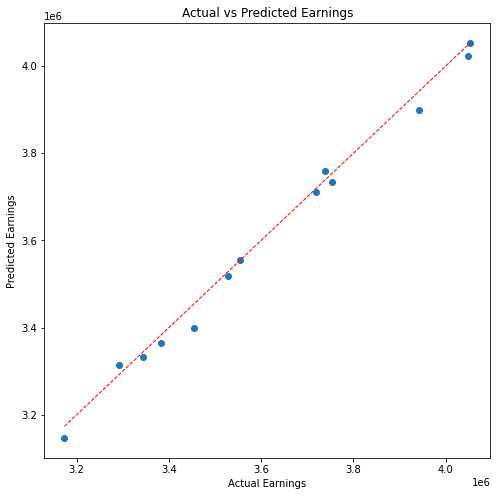

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = ['sincestart', 'trip_miles', 'base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
x= avg_data[features]
y = avg_data['uber_earnings']
 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions,)  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=1)  
plt.title('Actual vs Predicted Earnings')
plt.xlabel('Actual Earnings')
plt.ylabel('Predicted Earnings')
plt.show()

# TIME SERIES FORECASTING [PREDICTING NEXT 30 DAYS]

Predicted Earnings for the Future:
[1450659.59147062 2091621.72063921 4443387.56077237 3242072.74517038
  817677.30155512 3199401.20300202 4999001.81544194  801294.23305919
 3611185.13024143 2338912.1815403  1227460.21000573 4825635.39761935
 2763663.55815061 3791263.52665409 4809705.03466441 2255787.93489781
 5368710.46627229 1891534.07490847 3175876.8839637  4570515.60861571
 3096494.9048795  2441266.46165809 2132411.58115775 2603825.46574008
 3886053.07674251 1985953.73616175 3390219.15254687 4450139.57100378
 4534265.89666995 2857644.98124682]


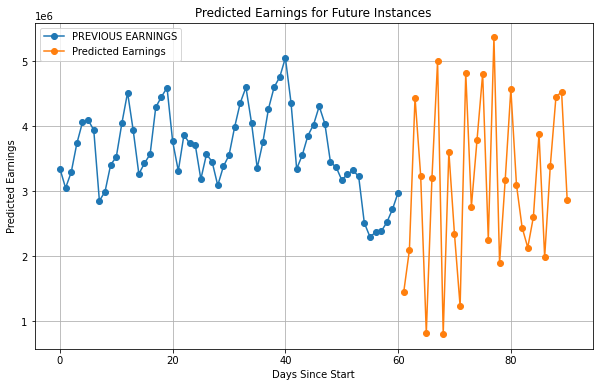

In [13]:
future_data = pd.DataFrame({
    'sincestart': np.arange(max(data['sincestart']) + 1, max(data['sincestart']) + 31),  
    'trip_miles': np.random.uniform(low=avg_data['trip_miles'].min(), high=avg_data['trip_miles'].mean(), size=30), 
    'base_passenger_fare': np.random.uniform(low=avg_data['base_passenger_fare'].min(), high=avg_data['base_passenger_fare'].mean(), size=30),  
    'tolls': np.random.uniform(low=avg_data['tolls'].min(), high=avg_data['tolls'].mean(), size=30), 
    'sales_tax': np.random.uniform(low=avg_data['sales_tax'].min(), high=avg_data['sales_tax'].mean(), size=30),
    'congestion_surcharge': np.random.uniform(low=avg_data['congestion_surcharge'].min(), high=avg_data['congestion_surcharge'].mean(), size=30),  
    'airport_fee': np.random.uniform(low=avg_data['airport_fee'].min(), high=avg_data['airport_fee'].mean(), size=30),
    'tips': np.random.uniform(low=avg_data['tips'].min(), high=avg_data['tips'].mean(), size=30),
    'driver_pay': np.random.uniform(low=avg_data['driver_pay'].min(), high=avg_data['driver_pay'].mean(), size=30)  
})

future_predictions = model.predict(future_data[features])

print("Predicted Earnings for the Future:")
print(future_predictions)
plt.figure(figsize=(10, 6))
plt.plot(avg_data['sincestart'], avg_data['uber_earnings'], marker='o', label='PREVIOUS EARNINGS')
plt.plot(future_data['sincestart'], future_predictions, marker='o', label='Predicted Earnings')

plt.title('Predicted Earnings for Future Instances')
plt.xlabel('Days Since Start')
plt.ylabel('Predicted Earnings')
plt.legend()
plt.grid(True)

plt.show()

In [7]:
import datetime
startTime = datetime.datetime.now()
uber_earnings=[]
drivers_pay=[]
taxes=[]

for filename in os.listdir('./data/'):
    file_path = os.path.join('./data/', filename)
    data = pq.read_table(file_path)
    data=data.to_pandas()
    uber=data[data['hvfhs_license_num']=="HV0003"]
    uber['airport_fee'].fillna(0, inplace=True)
    uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']-uber['sales_tax']
    print("TOTAL EARNINGS IN THIS MONTH:",round(uber['uber_earnings'].sum()))
    uber_earnings.append(uber['uber_earnings'].sum())
    drivers_pay.append(uber['driver_pay'].sum())
    taxes.append(uber['sales_tax'].sum())
    
print("TOTAL UBER EARNINGS THIS YEAR:",sum(uber_earnings),"\n TOTAL SUM OF DRIVERS PAY:",sum(drivers_pay),"\nTOTAL TAXES RECIEVED THIS YEAR",sum(taxes))
endTime = datetime.datetime.now()
print("TOTAL TIME FOR EXECUTING THIS CODE",endTime - startTime)
    

TOTAL EARNINGS IN THIS MONTH: 30020228
TOTAL EARNINGS IN THIS MONTH: 26810243
TOTAL EARNINGS IN THIS MONTH: 36448319
TOTAL EARNINGS IN THIS MONTH: 44515842
TOTAL EARNINGS IN THIS MONTH: 46464159
TOTAL EARNINGS IN THIS MONTH: 51195093
TOTAL EARNINGS IN THIS MONTH: 56884967
TOTAL EARNINGS IN THIS MONTH: 52121228
TOTAL EARNINGS IN THIS MONTH: 51231113
TOTAL EARNINGS IN THIS MONTH: 49626414
TOTAL EARNINGS IN THIS MONTH: 58022697
TOTAL EARNINGS IN THIS MONTH: 63164271
TOTAL UBER EARNINGS THIS YEAR: 566504574.1099999 
 TOTAL SUM OF DRIVERS PAY: 2288988531.8599987 
TOTAL TAXES RECIEVED THIS YEAR 235272002.90000004
TOTAL TIME FOR EXECUTING THIS CODE 0:08:22.330055


In [29]:
print("TOTAL UBER EARNINGS THIS YEAR:",sum(uber_earnings),"\n TOTAL SUM OF DRIVERS PAY:",sum(drivers_pay),"\nTOTAL TAXES RECIEVED THIS YEAR",sum(taxes))


TOTAL UBER EARNINGS THIS YEAR: 566504574.1099999 
 TOTAL SUM OF DRIVERS PAY: 2288988531.8599987 
TOTAL TAXES RECIEVED THIS YEAR 235272002.90000004


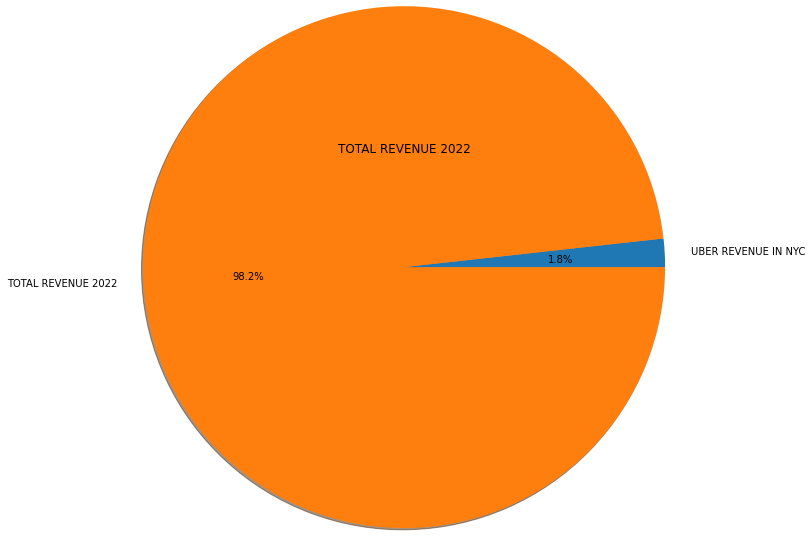

In [6]:
uber_earnings=566504574
plt.pie([uber_earnings,31800000000],labels=["UBER REVENUE IN NYC","TOTAL REVENUE 2022"],shadow = True, radius = 3, autopct = '%1.1f%%')
plt.title('TOTAL REVENUE 2022')
plt.show()